# United States Weather Bureau Method for Evaporation

This method is based on the Penman equation for evaporation, and is dependant on the daily average air temperature, relative humidity, daily solar radiation, and the average daily wind speed

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
hollis = pd.read_csv("data/Hollis.csv")
hollis.head()

,Date / Time,AirTC (Avg),RH,SlrkW (Avg),SlrjJ (Tot),WS ms (Avg),Wind Dir,T108 C (Avg),HBr3W,Rain mm (Tot)
0,7/17/2014 15:30,26.94,67.85,0.412,609.3776,1.667,335.900,31.21,221.5,0.0
1,7/17/2014 16:00,26.89,69.88,0.387,696.9075,1.618,59.220,31.45,221.4,0.0
2,7/17/2014 16:30,26.45,73.05,0.154,277.9549,1.753,52.930,31.25,221.3,0.0
3,7/17/2014 17:00,26.27,73.78,0.183,328.9092,1.879,2.172,30.91,220.9,0.0
4,7/17/2014 17:30,25.95,75.34,0.060,107.9211,1.944,33.750,30.47,220.8,0.0


In [3]:
df = hollis[["Date / Time", "RH", "SlrkW (Avg)", "WS ms (Avg)", "T108 C (Avg)"]]    #Using pan temp since air temp has some weird values
df.columns = ['date', 'humidity', "energy", "wind", 'temp']
df.dropna(inplace=True)
df["date"] = pd.to_datetime(df.date).dt.normalize()
df.describe()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,humidity,energy,wind,temp
count,20054.000000,20054.000000,20054.000000,20054.000000
mean,80.269694,0.174742,1.167754,27.002141
std,54.656236,0.262976,0.797486,2.911931
min,0.612000,0.000000,0.000000,20.460000
25%,7.816250,0.000000,0.429000,24.770000
50%,91.100000,0.003000,1.087000,26.440000
75%,119.000000,0.294000,1.739000,28.960000
max,217.200000,1.150000,4.445000,37.270000


Notice the quite high and low humidity values? Wind and temp make sense and I don't know what energy is supposed to look like. Humidity will be fixed later on

In [4]:
df = df.groupby('date', as_index=False, sort=False).mean()
df.head()

,date,humidity,energy,wind,temp
0,2014-07-17,81.728235,0.072294,1.359412,28.745294
1,2014-07-18,89.427083,0.058667,1.032292,24.944583
2,2014-07-19,86.988125,0.126229,1.284333,25.877708
3,2014-07-20,88.730833,0.096042,1.010750,25.772083
4,2014-07-21,82.476458,0.204146,1.176583,27.385000


In [5]:
df.loc[df.humidity < 70, 'humidity'] = 80
df.loc[df.humidity > 100, 'humidity'] = 80
df.describe()

,humidity,energy,wind,temp
count,420.000000,420.000000,420.000000,420.000000
mean,82.476255,0.174555,1.166152,27.004829
std,4.369920,0.049676,0.395389,1.336323
min,76.369583,0.016667,0.383313,23.325000
25%,80.000000,0.140318,0.864198,25.968125
50%,80.000000,0.179625,1.134688,26.921667
75%,83.773906,0.210214,1.442302,28.067812
max,99.952083,0.277042,2.390104,30.116458


## Relative Humidity

First, a component of relative humidity is calculated based on the the average daily relative humidity f, in percent.

\begin{equation*}
X = 1 - {f\over 100}
\end{equation*}

In [6]:
df['CRH'] = 1 - (df['humidity'])/100
df.head()

,date,humidity,energy,wind,temp,CRH
0,2014-07-17,81.728235,0.072294,1.359412,28.745294,0.182718
1,2014-07-18,89.427083,0.058667,1.032292,24.944583,0.105729
2,2014-07-19,86.988125,0.126229,1.284333,25.877708,0.130119
3,2014-07-20,88.730833,0.096042,1.010750,25.772083,0.112692
4,2014-07-21,82.476458,0.204146,1.176583,27.385000,0.175235


## Dewpoint Temperature

\begin{equation*}
T_d = T_a - \left[(14.55 + 0.114T_a)X + [(2.5 + 0.007T_a)X]^3 + (15.9 + 0.117T_a)X^{14}\right]
\end{equation*}

where T<sub>a</sub> is the average daily temperature in degrees Celsius. Yes, that's quite an equation

In [7]:
df['DT'] = df['temp']-(14.55+0.114*df['temp'])*df['CRH']+((2.5+0.007*df['temp'])*df['CRH'])**3+(15.9+0.117*df['temp'])*df['CRH']**14
df.head()

,date,humidity,energy,wind,temp,CRH,DT
0,2014-07-17,81.728235,0.072294,1.359412,28.745294,0.182718,25.608225
1,2014-07-18,89.427083,0.058667,1.032292,24.944583,0.105729,23.128177
2,2014-07-19,86.988125,0.126229,1.284333,25.877708,0.130119,23.643083
3,2014-07-20,88.730833,0.096042,1.010750,25.772083,0.112692,23.828889
4,2014-07-21,82.476458,0.204146,1.176583,27.385000,0.175235,24.393200


## Dimensionless Ratios

\begin{equation*}
{\Delta \over{\Delta + \gamma}} = \left[1+{0.66\over{(0.00815T_a + 0.8912)^7}}\right]^{-1}
\end{equation*}

Just do it. Delta is the gradient of saturated vapour pressure and Gamma is something called the psychromatic constant

In [8]:
df['ratiodelta'] = (1+(0.66/(0.00815*df['temp']+0.8912)**7))**-1
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta
0,2014-07-17,81.728235,0.072294,1.359412,28.745294,0.182718,25.608225,0.776076
1,2014-07-18,89.427083,0.058667,1.032292,24.944583,0.105729,23.128177,0.740312
2,2014-07-19,86.988125,0.126229,1.284333,25.877708,0.130119,23.643083,0.749521
3,2014-07-20,88.730833,0.096042,1.010750,25.772083,0.112692,23.828889,0.748493
4,2014-07-21,82.476458,0.204146,1.176583,27.385000,0.175235,24.393200,0.763804


\begin{equation*}
{\gamma \over{\Delta + \gamma}} = {1 - {\Delta\over{\Delta+\gamma}}}
\end{equation*}

In [9]:
df['ratiogamma'] = 1 - df['ratiodelta']
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta,ratiogamma
0,2014-07-17,81.728235,0.072294,1.359412,28.745294,0.182718,25.608225,0.776076,0.223924
1,2014-07-18,89.427083,0.058667,1.032292,24.944583,0.105729,23.128177,0.740312,0.259688
2,2014-07-19,86.988125,0.126229,1.284333,25.877708,0.130119,23.643083,0.749521,0.250479
3,2014-07-20,88.730833,0.096042,1.010750,25.772083,0.112692,23.828889,0.748493,0.251507
4,2014-07-21,82.476458,0.204146,1.176583,27.385000,0.175235,24.393200,0.763804,0.236196


## Effective Net Radiation

\begin{equation*}
Q_n = 0.00714Q_s + 0.00000526Q_s(T_a + 17.8)^{1.87} + 0.00000394Q_s^2 - 0.00000000239Q_s^2(T_a-7.2)^2-1.02
\end{equation*}

where Q<sub>s</sub> is the daily solar radiation in calories per square centimeter. We need to do a conversion since the data we have is in kilowatt-hours

In [10]:
df['energy'] = df['energy']*86.011

In [11]:
df['rad'] = 0.00714*df['energy']+0.00000526*df['energy']*(df['temp']+17.8)**1.87+0.000000394*df['energy']**2-0.00000000239*df['energy']**2*(df['temp']-7.2)**2-1.02
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta,ratiogamma,rad
0,2014-07-17,81.728235,6.218089,1.359412,28.745294,0.182718,25.608225,0.776076,0.223924,-0.932620
1,2014-07-18,89.427083,5.045979,1.032292,24.944583,0.105729,23.128177,0.740312,0.259688,-0.954218
2,2014-07-19,86.988125,10.857097,1.284333,25.877708,0.130119,23.643083,0.749521,0.250479,-0.875854
3,2014-07-20,88.730833,8.260640,1.010750,25.772083,0.112692,23.828889,0.748493,0.251507,-0.910545
4,2014-07-21,82.476458,17.558787,1.176583,27.385000,0.175235,24.393200,0.763804,0.236196,-0.779909


## Vapour Pressure Difference

\begin{equation*}
e_s-e_a=33.86\left[(0.00738T_a+0.8072)^8 - (0.00738T_d + 0.8072)^8\right]
\end{equation*}

where e<sub>s</sub> is the saturation vapour pressure in millibars nd e<sub>a</sub> is the vapour pressure at the temperature of the air

In [12]:
df['vapour'] = 33.86*(((0.00738*df['temp']+0.8072)**8)-((0.00738*df['DT']+0.8072)**8))
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta,ratiogamma,rad,vapour
0,2014-07-17,81.728235,6.218089,1.359412,28.745294,0.182718,25.608225,0.776076,0.223924,-0.932620,6.626309
1,2014-07-18,89.427083,5.045979,1.032292,24.944583,0.105729,23.128177,0.740312,0.259688,-0.954218,3.258145
2,2014-07-19,86.988125,10.857097,1.284333,25.877708,0.130119,23.643083,0.749521,0.250479,-0.875854,4.163760
3,2014-07-20,88.730833,8.260640,1.010750,25.772083,0.112692,23.828889,0.748493,0.251507,-0.910545,3.627889
4,2014-07-21,82.476458,17.558787,1.176583,27.385000,0.175235,24.393200,0.763804,0.236196,-0.779909,5.913547


## Evaporation

\begin{equation*}
E_a=(e_s-e_a)^{0.88}(0.42+0.0029v_p)
\end{equation*}

where v<sub>p</sub> is average wind speed in kilometers per day. Therefore we need to do another conversion since the wind speed we have is in meters per second apparently

In [13]:
df['wind'] = df['wind']/100*86400

In [14]:
df['evapA'] = df['vapour']**0.88*(0.42+0.0029*df['wind'])
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta,ratiogamma,rad,vapour,evapA
0,2014-07-17,81.728235,6.218089,1174.531765,28.745294,0.182718,25.608225,0.776076,0.223924,-0.932620,6.626309,20.205992
1,2014-07-18,89.427083,5.045979,891.900000,24.944583,0.105729,23.128177,0.740312,0.259688,-0.954218,3.258145,8.501129
2,2014-07-19,86.988125,10.857097,1109.664000,25.877708,0.130119,23.643083,0.749521,0.250479,-0.875854,4.163760,12.764774
3,2014-07-20,88.730833,8.260640,873.288000,25.772083,0.112692,23.828889,0.748493,0.251507,-0.910545,3.627889,9.176786
4,2014-07-21,82.476458,17.558787,1016.568000,27.385000,0.175235,24.393200,0.763804,0.236196,-0.779909,5.913547,16.091793


Reservoir evaporation is then given by:

\begin{equation*}
E = 0.7\left[{\Delta\over{\Delta+\gamma}}Q_n + {\gamma \over{\Delta + \gamma}}E_a\right] 
\end{equation*}

where E somehow turns out to be in mm

In [15]:
df['E'] = 0.7*(df['ratiodelta']*df['rad']+df['ratiogamma']*df['evapA'])
df.head()

,date,humidity,energy,wind,temp,CRH,DT,ratiodelta,ratiogamma,rad,vapour,evapA,E
0,2014-07-17,81.728235,6.218089,1174.531765,28.745294,0.182718,25.608225,0.776076,0.223924,-0.932620,6.626309,20.205992,2.660569
1,2014-07-18,89.427083,5.045979,891.900000,24.944583,0.105729,23.128177,0.740312,0.259688,-0.954218,3.258145,8.501129,1.050859
2,2014-07-19,86.988125,10.857097,1109.664000,25.877708,0.130119,23.643083,0.749521,0.250479,-0.875854,4.163760,12.764774,1.778587
3,2014-07-20,88.730833,8.260640,873.288000,25.772083,0.112692,23.828889,0.748493,0.251507,-0.910545,3.627889,9.176786,1.138545
4,2014-07-21,82.476458,17.558787,1016.568000,27.385000,0.175235,24.393200,0.763804,0.236196,-0.779909,5.913547,16.091793,2.243579


## Monthly Evaporation

In [16]:
month_df = df[['date', 'E']]
month_df.set_index('date', inplace=True)
month_df.head()

,E
date,
2014-07-17,2.660569
2014-07-18,1.050859
2014-07-19,1.778587
2014-07-20,1.138545
2014-07-21,2.243579


In [17]:
month_df_sum = month_df.groupby(pd.Grouper(freq="M")).sum()
month_df_sum.head()

,E
date,
2014-07-31,29.651483
2014-08-31,49.364594
2014-09-30,0.981232
2014-10-31,26.470428
2014-11-30,41.832963


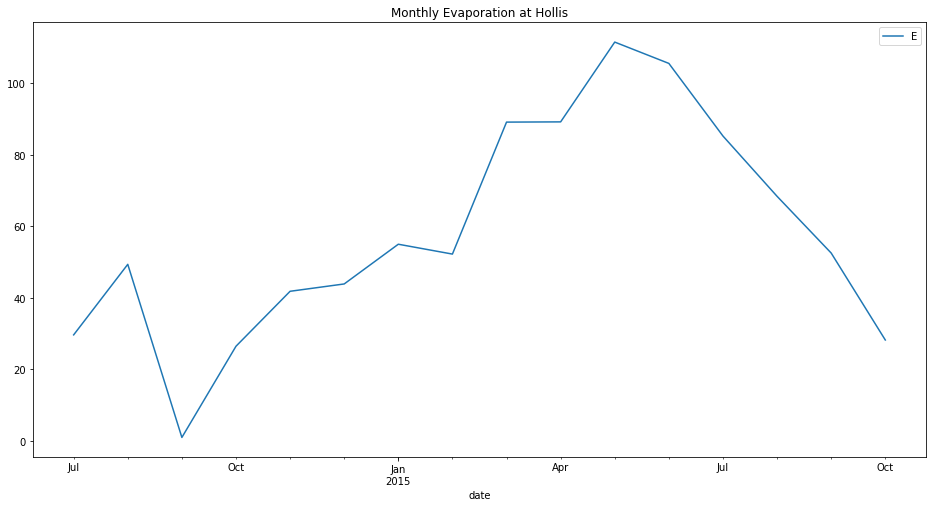

In [18]:
month_df_sum.plot(figsize=(16,8), title='Monthly Evaporation at Hollis')


In [19]:
month_df_avg = month_df.groupby(pd.Grouper(freq="M")).mean()
month_df_avg.head()

,E
date,
2014-07-31,1.976766
2014-08-31,1.592406
2014-09-30,0.981232
2014-10-31,1.058817
2014-11-30,1.394432


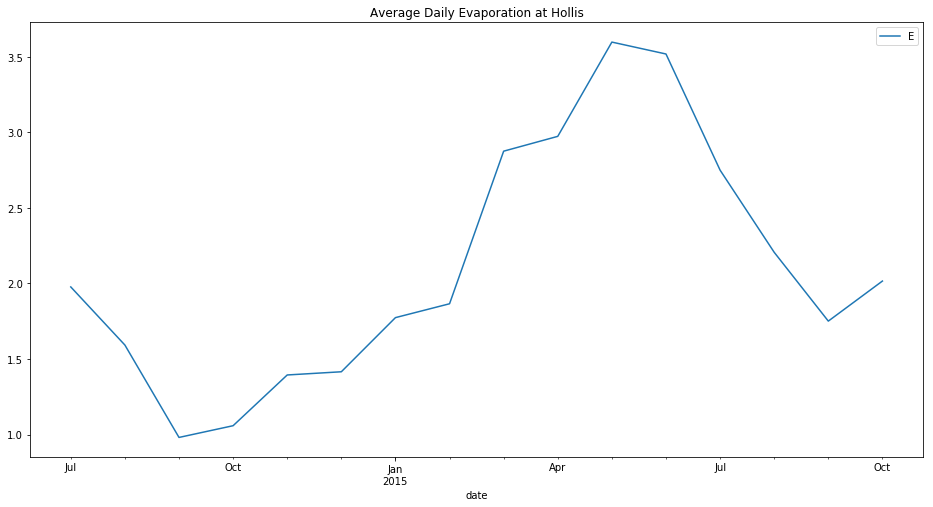

In [20]:
month_df_avg.plot(figsize=(16,8), title='Average Daily Evaporation at Hollis')

## Print useable table of values

In [21]:
month_df_sum.to_csv("results/USWB_total.csv")
month_df_avg.to_csv("results/USWB_average.csv")

## References

https://pubs.usgs.gov/sir/2012/5202/pdf/sir2012-5202.pdf